In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier as mlp
from sklearn.ensemble import AdaBoostClassifier as abc
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.svm import SVC as svc

# Data Preprocessing

In [2]:
data = pd.read_pickle('data_4')
data = data.rename(columns = {'genre_top':'target'})
data = data.sample(frac=1, random_state=42)
data.head()

,chroma_cens,chroma_cens.1,chroma_cens.2,chroma_cens.3,chroma_cens.4,chroma_cens.5,chroma_cens.6,chroma_cens.7,chroma_cens.8,chroma_cens.9,...,zcr.5,zcr.6,track_title,track_title,genres,genres_all,target,artist_id,artist_id,name
track_id,,,,,,,,,,,,,,,,,,,,,
31568,-0.253879,-0.237872,-0.827132,0.164924,0.072617,0.715829,-0.319894,-0.488374,-0.397094,-0.450271,...,3.386286,0.044134,Morning Touches,Morning News,"[15, 182]","[182, 15]",Electronic,6611,7797,Nameless Dancers
101128,-0.483836,-0.321514,-0.141951,-0.451974,-0.631840,-0.472594,1.026899,0.040170,-0.508121,-0.413764,...,4.852969,0.023291,Live on WFMU's Beastin' the Airwaves! with Kei...,Swingin,"[25, 85]","[25, 12, 85]",Rock,16156,18168,Flagland
38314,-0.525965,-0.122689,-0.157177,0.226547,-0.003503,0.915957,-0.012258,0.844315,0.169801,-0.693645,...,0.704593,0.019690,Live at Pacific Parc 08/07/2009,I Hate The Neighbours,"[12, 26]","[26, 12]",Rock,7682,9158,Bobbie Peru
116203,0.204815,1.805994,-0.800902,1.923259,-0.983459,3.362511,-0.587175,-1.001314,0.350301,-1.121838,...,-0.193462,0.019869,Open Road,End of the Road,[12],[12],Rock,17889,19472,Squire Tuck
65453,2.154378,0.796645,0.728458,2.290709,0.778190,1.232334,0.942508,2.938278,0.293847,-0.369958,...,0.317747,0.019635,Put Me Down And Spin Me Around,Crust Dweller,[38],[38],Experimental,11789,7135,Bomis Prendin


Lets have a look at the distrubution of the labels, i.e, the genres.

In [3]:
labels = ['Experimental', 'Hip-Hop', 'Electronic', 'Rock']
label_ditribution = (data[['name', 'target']].groupby('target').count()/data.shape[0]).T
label_ditribution = label_ditribution[labels].T

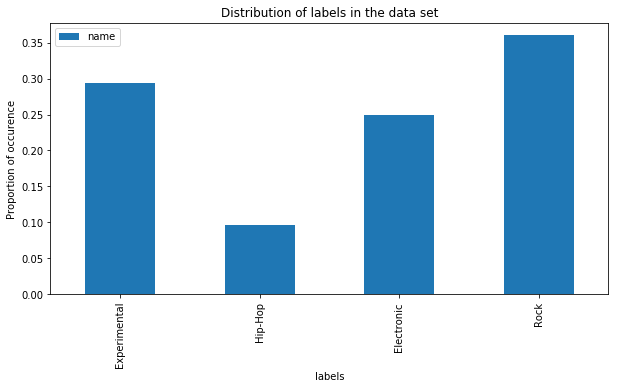

In [4]:
label_ditribution.plot(kind='bar', figsize=(10,5))
plt.xlabel('labels')
plt.ylabel('Proportion of occurence')
plt.title('Distribution of labels in the data set')
plt.show()

As we can see in the plot above, the distribution of labels is far from being balanced. In order to remove the bias, we will balance the labels among the the 4 genres equally.

In [5]:
#we filter tracks according to their corresponding genres
experimental = data[data['target'] == 'Experimental']
hip_hop = data[data['target'] == 'Hip-Hop']
electro = data[data['target'] == 'Electronic']
rock = data[data['target'] == 'Rock']

#we take a sample corresponding to the minimum of training examples among all 4 genres
n1 = experimental.shape
n2 = hip_hop.shape
n3 = electro.shape
n4 = rock.shape
min_samples = min(n1, n2, n3, n4)[0]
s1 = experimental.sample(n=min_samples, random_state=42)
s2 = electro.sample(n=min_samples, random_state=42)
s3 = hip_hop.sample(n=min_samples, random_state=42)
s4 = rock.sample(n=min_samples, random_state=42)
sampled_data = pd.concat([s1, s2, s3, s4])

**Feature Selection and sampling**

In [6]:
#List of separated set of features
chroma_cens = np.arange(0,84)
chroma_cqt = np.arange(84, 168)
chroma_stft = np.arange(168, 252)
mfcc = np.arange(252, 392)
rmse = np.arange(392, 399)
spectral_bandwidth = np.arange(399, 406)
spectral_centroid = np.arange(406, 413)
spectral_contrast = np.arange(413, 462)
spectral_rolloff = np.arange(462, 469)
tonnetz = np.arange(469, 511)
zcr = np.arange(511, 518)
all_ = np.arange(0, 518)

def select_features(df, indices):
    print('New sample with shape {} created and {} labels'.format(np.shape(df.iloc[:,indices]), np.shape(df.loc[:, 'target'])))
    return df.iloc[:,indices], df.loc[:,'target']

In [7]:
def gen_data(d, ind, size_ratio) : 
    
    d = d.sample(frac=size_ratio, random_state=42)
    X, y = select_features(d, ind)
    encoder = LabelEncoder() #Used to encode categorical labels
    y = encoder.fit_transform(y) 
    
    #Split Data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.1)
    
    #Normalize data to have them on same scale and to improve performance of ML models
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

# Hyperparameters Tuning and Models Comparison

In [8]:
ratio = 0.1 #Small data set for 
X_train_validate, X_test_validate, y_train_validate, y_test_validate = gen_data(sampled_data, all_, ratio)

New sample with shape (1197, 518) created and (1197,) labels


In [9]:
params = []

#logistic Regression
log_grid = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
log_p = (LogisticRegression(random_state=42), log_grid, 'Logistic Regression')
params.append(log_p)

#K-Nearest Neighbors
knn_grid = {'n_neighbors' : [1, 3, 5, 7, 9, 11], 'weights' : ['uniform', 'distance'], 'metric':['euclidean']}
knn_p = (knn(), knn_grid, 'K-Nearest Neighbors')
params.append(knn_p)

#Linear SVC along with OnevsRestClassifier
l_svc_grid = {'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
l_svc_p = (svc(kernel='linear', random_state=42), l_svc_grid, 'OneVsRestClassifier with Linear SVC base')
params.append(l_svc_p)

#SVC with infinite feature MAP (rbf)
rbf_grid = {'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma': [1e-3, 1e-4]}
rbf_p = (svc(kernel='rbf',random_state=42), rbf_grid, 'SVC with infinite feature MAP (rbf)')
params.append(rbf_p)

#Multi-Layer Perceptron
mlp_grid = {
    'hidden_layer_sizes': [(100,100), (100, 100, 100), (200, 200), (200, 200, 200)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant','adaptive'],
}
mlp_p = (mlp(max_iter=1000, early_stopping = True), mlp_grid, 'Multi-Layer Perceptron')
params.append(mlp_p)

In [10]:
def parameters_tuning(model, param_grid, model_name) :
    gs = GridSearchCV(model, cv=5, n_jobs=4, param_grid=param_grid)
    gs.fit(X_train_validate, y_train_validate)
    
    # Best parameters set
    print('Model : {}'.format(model_name))
    print('Best parameters found:\n', gs.best_params_)
    print('Accuracy on training set: {:.2f}'
         .format(gs.score(X_train_validate, y_train_validate)))
    print('Accuracy on test set: {:.2f}'
         .format(gs.score(X_test_validate, y_test_validate)))
    
    return (model, gs.best_params_, model_name)

In [11]:
models_parameters = []
for i in range(len(params)) :
    current = params[i]
    md = current[0]
    grid = current[1]
    name = current[2]
    estimator = parameters_tuning(md, grid, name)
    models_parameters.append(estimator)
    print('---------------------------------------------')

C:\Anaconda\envs\ada\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\envs\ada\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Model : Logistic Regression
Best parameters found:
 {'C': 1, 'penalty': 'l1'}
Accuracy on training set: 0.83
Accuracy on test set: 0.63
---------------------------------------------
Model : K-Nearest Neighbors
Best parameters found:
 {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
Accuracy on training set: 0.68
Accuracy on test set: 0.61
---------------------------------------------
Model : OneVsRestClassifier with Linear SVC base
Best parameters found:
 {'C': 0.1}
Accuracy on training set: 0.79
Accuracy on test set: 0.62
---------------------------------------------
Model : SVC with infinite feature MAP (rbf)
Best parameters found:
 {'C': 100, 'gamma': 0.001}
Accuracy on training set: 0.83
Accuracy on test set: 0.68
---------------------------------------------


C:\Anaconda\envs\ada\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Model : Multi-Layer Perceptron
Best parameters found:
 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (200, 200), 'learning_rate': 'constant', 'solver': 'adam'}
Accuracy on training set: 0.81
Accuracy on test set: 0.60
---------------------------------------------


# Predictions on full data set

In [12]:
ratio = 1 #Small data set for 
X_train, X_test, y_train, y_test = gen_data(sampled_data, all_, 1)

New sample with shape (11968, 518) created and (11968,) labels


In [13]:
def make_predictions(model) :
    m = model[0]
    m.fit(X_train, y_train)
    
    # Best parameters set
    print('Model : {}'.format(model[2]))
    print('Accuracy on training set: {:.2f}'
         .format(m.score(X_train, y_train)))
    print('Accuracy on test set: {:.2f}'
         .format(m.score(X_test, y_test)))

In [14]:
for i in range(len(models_parameters)) :
    estimator = models_parameters[i]
    make_predictions(estimator)
    print('---------------------------------------------')

C:\Anaconda\envs\ada\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\envs\ada\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Model : Logistic Regression
Accuracy on training set: 0.77
Accuracy on test set: 0.76
---------------------------------------------
Model : K-Nearest Neighbors
Accuracy on training set: 0.77
Accuracy on test set: 0.66
---------------------------------------------
Model : OneVsRestClassifier with Linear SVC base
Accuracy on training set: 0.79
Accuracy on test set: 0.76
---------------------------------------------


C:\Anaconda\envs\ada\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Model : SVC with infinite feature MAP (rbf)
Accuracy on training set: 0.68
Accuracy on test set: 0.68
---------------------------------------------
Model : Multi-Layer Perceptron
Accuracy on training set: 0.77
Accuracy on test set: 0.75
---------------------------------------------
